In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

from sklearn import metrics
from sklearn import calibration
from sklearn.preprocessing import StandardScaler

import pickle

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load data
scorecard_df = pd.read_csv('../data/Ex1 - Modeling sample.csv')
scorecard_df.head()

,loanid,model1,model2,target,sample
0,1,0.014187,0.010911,0,testing
1,2,0.016760,0.029098,0,testing
2,3,0.015092,0.019482,0,testing
3,4,0.015403,0.019324,0,testing
4,5,0.020180,0.031430,0,testing


# Data Analysis

Text(0, 0.5, 'Loans')

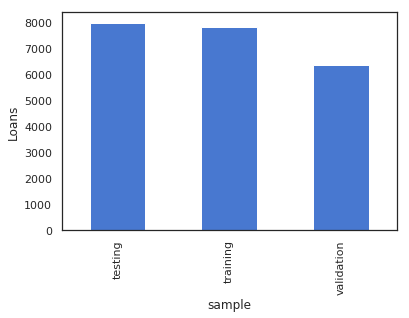

In [3]:
# number of loans in each sample
scorecard_df.groupby('sample').loanid.count().plot.bar()
plt.ylabel('Loans')

Default class is 2.4% of total testing set loans
Default class is 1.9% of total training set loans
Default class is 1.9% of total validation set loans


Text(0, 0.5, 'Loans')

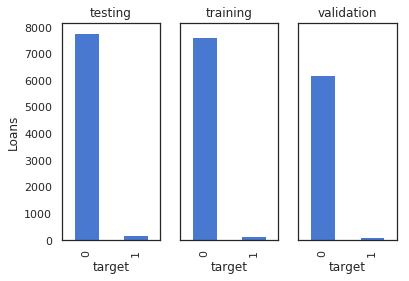

In [4]:
# look at class balance per sample
fig,ax = plt.subplots(1,3, sharey=True)
ax = np.ravel(ax)
for i,sample in enumerate(scorecard_df['sample'].unique()):
    scorecard_df.query('sample == "{}"'.format(sample)).groupby('target').loanid.count().plot.bar(ax=ax[i])
    percentage = scorecard_df.query('sample == "{}"'.format(sample)).groupby('target').loanid.count().loc[1] / scorecard_df.query('sample == "{}"'.format(sample)).groupby('target').loanid.count().sum()
    print('Default class is {:2.1f}% of total {} set loans'.format(percentage*100,sample))
    ax[i].set_title(sample)
ax[0].set_ylabel('Loans')


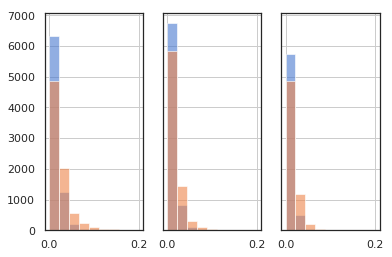

In [5]:
# look at distribution of scores per sample
fig,ax = plt.subplots(1,3, sharey=True)
ax = np.ravel(ax)
for i,sample in enumerate(scorecard_df['sample'].unique()):
    scorecard_df.query('sample == "{}"'.format(sample)).model1.hist(bins=np.linspace(0,0.2,10),alpha=.6,ax=ax[i])
    scorecard_df.query('sample == "{}"'.format(sample)).model2.hist(bins=np.linspace(0,0.2,10),alpha=.6,ax=ax[i])

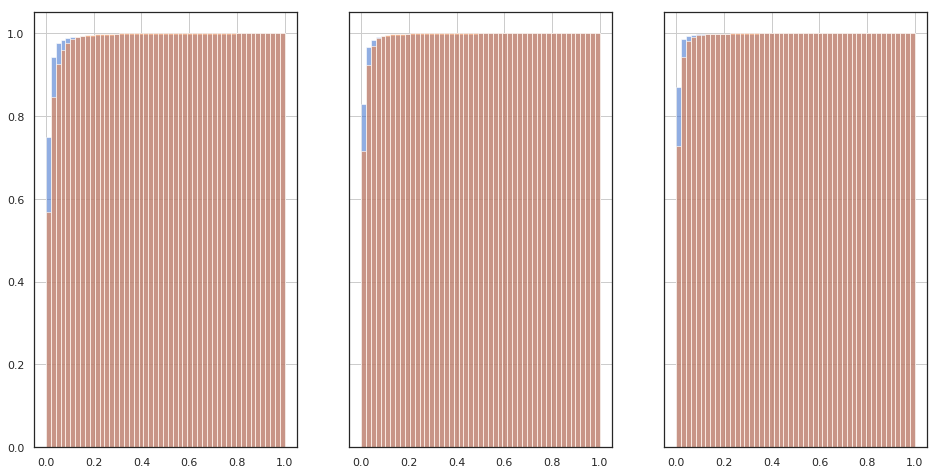

In [6]:
# look at distribution of scores per sample
fig,ax = plt.subplots(1,3,figsize=(16,8), sharey=True)
ax = np.ravel(ax)
for i,sample in enumerate(scorecard_df['sample'].unique()):
    scorecard_df.query('sample == "{}"'.format(sample)).model1.hist(bins=np.linspace(0,1),alpha=.6,ax=ax[i],density=True, cumulative=True)
    scorecard_df.query('sample == "{}"'.format(sample)).model2.hist(bins=np.linspace(0,1),alpha=.6,ax=ax[i],density=True,cumulative=True)

# Classification metrics for the models

In [7]:
# roc auc score
for i,sample in enumerate(scorecard_df['sample'].unique()):
    auc =[]
    for _ in range(40):
        # bootstrap to get variation
        temp_df = scorecard_df.query('sample == "{}"'.format(sample)).sample(1000)
        auc.append(metrics.roc_auc_score(temp_df.target, temp_df.model1))
    print(sample, 'model1','{} $\pm$ {}'.format(np.mean(auc), np.std(auc)))

testing model1 0.7341094906948282 $\pm$ 0.03939504715868517
training model1 0.7093815694982464 $\pm$ 0.0531218478399219
validation model1 0.6579398345697812 $\pm$ 0.053933110864138906


In [8]:
# roc auc score
for i,sample in enumerate(scorecard_df['sample'].unique()):
    auc =[]
    for _ in range(40):
        # bootstrap to get variation
        temp_df = scorecard_df.query('sample == "{}"'.format(sample)).sample(1000)
        auc.append(metrics.roc_auc_score(temp_df.target, temp_df.model2))
    print(sample, 'model1','{} $\pm$ {}'.format(np.mean(auc), np.std(auc)))

testing model1 0.7277853788260015 $\pm$ 0.048955815711103245
training model1 0.6857305822361703 $\pm$ 0.07105813033686618
validation model1 0.6276727366669681 $\pm$ 0.057644363154787444


## Calaculate the threshold where 80% of the loans will be accepted

In [9]:
# find the threshold where 80% of loans will be accepted
def theshold_loans(scores, p=.8):
    # finds threshold where p of loan will be accepted
    sort_scores = scores[np.argsort(scores)]
    n_accepted = []
    shape = len(sort_scores)
    for threshold in np.unique(sort_scores):
        n_accepted.append(np.abs((sort_scores <= threshold).sum()/shape - p))
    return np.unique(sort_scores)[np.argmin(n_accepted)]

Text(0, 0.5, 'true positive rate')

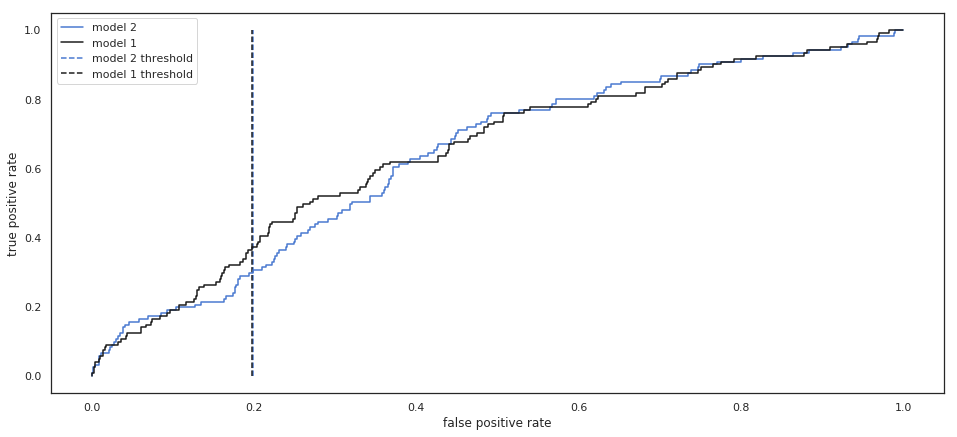

In [10]:
# do calculation and plot
sample = 'validation'
_,_=plt.subplots(figsize=(16,7))
fpr_model2,tpr_model2, thresholds_model2 = metrics.roc_curve(scorecard_df.query('sample == "{}"'.format(sample)).target, scorecard_df.query('sample == "{}"'.format(sample)).model2)
ind_model2 = np.abs(thresholds_model2 - theshold_loans(scorecard_df.query('sample == "{}"'.format(sample)).model2.values)).argmin()
plt.plot(fpr_model2, tpr_model2,label='model 2')
plt.vlines(fpr_model2[ind_model2],0,1,colors='b',linestyles='--', label='model 2 threshold')
fpr_model1,tpr_model1, thresholds_model1 = metrics.roc_curve(scorecard_df.query('sample == "{}"'.format(sample)).target, scorecard_df.query('sample == "{}"'.format(sample)).model1)
plt.plot(fpr_model1,tpr_model1, 'k',label='model 1')
ind_model1 = np.abs(thresholds_model1 - theshold_loans(scorecard_df.query('sample == "{}"'.format(sample)).model1.values)).argmin()
plt.vlines(fpr_model1[ind_model1],0,1,colors='k',linestyles='--', label='model 1 threshold')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

In [11]:
print('model 1 prob threshold is {:0.3f}. model 2 prob theshold is {:0.3f}'.format(thresholds_model1[ind_model1], thresholds_model2[ind_model2]))

model 1 prob threshold is 0.018. model 2 prob theshold is 0.024


Threshold where 80% of customers will be activated is the same between the 2 models, but model 1 will give a higher TPR

## metrics that need threshold

In [12]:
#model 1
use_thresh1 = thresholds_model1[ind_model1]
print(metrics.classification_report(scorecard_df.query('sample == "{}"'.format(sample)).target, scorecard_df.query('sample == "{}"'.format(sample)).model1>use_thresh1))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      6213
           1       0.03      0.36      0.06       121

    accuracy                           0.79      6334
   macro avg       0.51      0.58      0.47      6334
weighted avg       0.97      0.79      0.87      6334



In [13]:
#model 2
use_thresh2 = thresholds_model2[ind_model2]
print(metrics.classification_report(scorecard_df.query('sample == "{}"'.format(sample)).target, scorecard_df.query('sample == "{}"'.format(sample)).model2>use_thresh2))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      6213
           1       0.03      0.30      0.05       121

    accuracy                           0.79      6334
   macro avg       0.51      0.55      0.47      6334
weighted avg       0.96      0.79      0.87      6334



 Model 1 has better recal for defaults, but the weighted avg is the same.

## Confusion Matrix

Text(0.5, 1.0, 'Model 1')

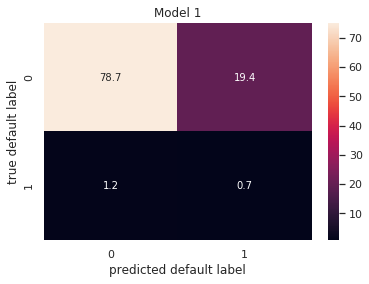

In [14]:
test_results = metrics.confusion_matrix(scorecard_df.query('sample == "{}"'.format(sample)).target, scorecard_df.query('sample == "{}"'.format(sample)).model1>use_thresh1,normalize='all')
sns.heatmap(test_results*100, robust=True, annot=True,fmt='3.1f')
plt.xlabel('predicted default label')
plt.ylabel('true default label')
plt.title('Model 1')

Text(0.5, 1.0, 'Model 2')

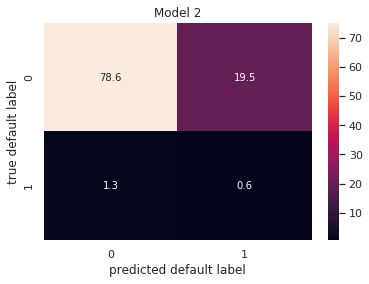

In [15]:
test_results = metrics.confusion_matrix(scorecard_df.query('sample == "{}"'.format(sample)).target, scorecard_df.query('sample == "{}"'.format(sample)).model2>use_thresh2,normalize='all')
sns.heatmap(test_results*100, robust=True, annot=True,fmt='3.1f')
plt.xlabel('predicted default label')
plt.ylabel('true default label')
plt.title('Model 2')

It is worse to have false positives when giving loans, since each false postive reduces portfolio yield. Model 1 has a lower FP rate (1.22 vs 1.34)

# How do models rank

In [16]:
scorecard_df['sample'].unique()

array(['testing', 'training', 'validation'], dtype=object)

In [17]:
# see if models are monotonic 
monotonic1 = dict()
monotonic2 = dict()
bins1,bins2 = None,None
for sample in scorecard_df['sample'].unique():
    # decile binning
    df = scorecard_df.query('sample == "{}"'.format(sample))
    if bins1 is None:
        df['decile1'],bins1 = pd.qcut(df.model1,10,retbins=True,)
        df['decile2'],bins2 = pd.qcut(df.model2,10,retbins=True,)
    else:
        df['decile1'],bins1 = pd.cut(df.model1,bins1,retbins=True,)
        df['decile2'],bins2 = pd.cut(df.model2,bins2,retbins=True,)
    monotonic1[sample] = df.groupby('decile1').target.sum() /df.groupby('decile1').target.count()
    monotonic2[sample] = df.groupby('decile2').target.sum() /df.groupby('decile2').target.count()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

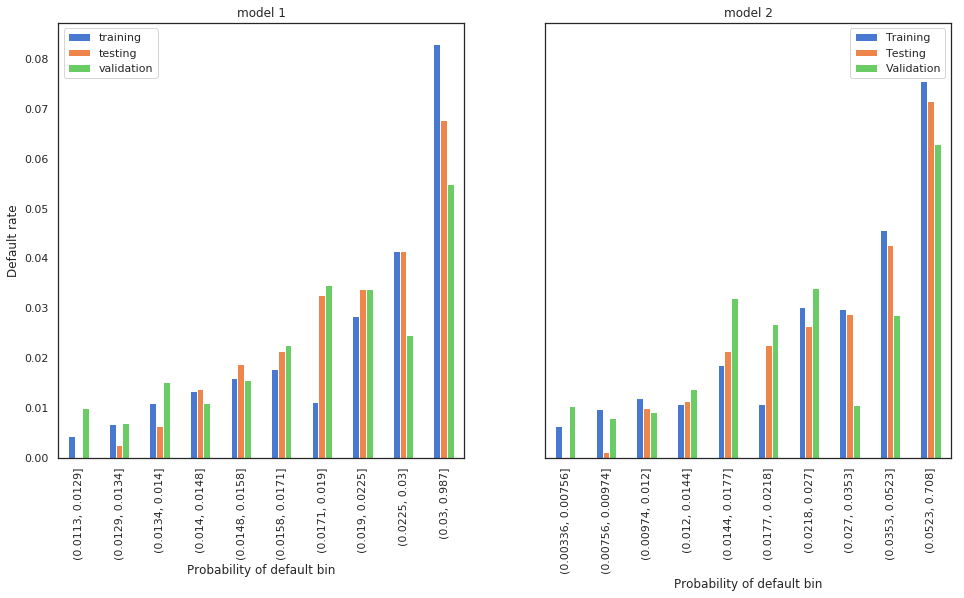

In [18]:
# Plot
fig, *ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax1,ax2 = np.ravel(ax)
joined_df = pd.DataFrame(monotonic1['training']).rename(columns={'target':'training'})
joined_df = joined_df.join(pd.DataFrame(monotonic1['testing']).rename(columns={'target':'testing'}))
joined_df = joined_df.join(pd.DataFrame(monotonic1['validation']).rename(columns={'target':'validation'}))
joined_df.plot.bar(ax=ax1)
ax1.set_ylabel('Default rate')
ax1.set_xlabel('Probability of default bin')
ax1.set_title('model 1')
joined_df = pd.DataFrame(monotonic2['training']).rename(columns={'target':'training'})
joined_df = joined_df.join(pd.DataFrame(monotonic2['testing']).rename(columns={'target':'testing'}))
joined_df = joined_df.join(pd.DataFrame(monotonic2['validation']).rename(columns={'target':'validation'}))
joined_df.plot.bar(ax=ax2)
ax2.set_xlabel('Probability of default bin')
ax2.set_title('model 2')
plt.legend(('Training', 'Testing', 'Validation'))

This is an by eye metric, but model 1 seems to be more monotonic than model 2

# Are models probabilites calibrated


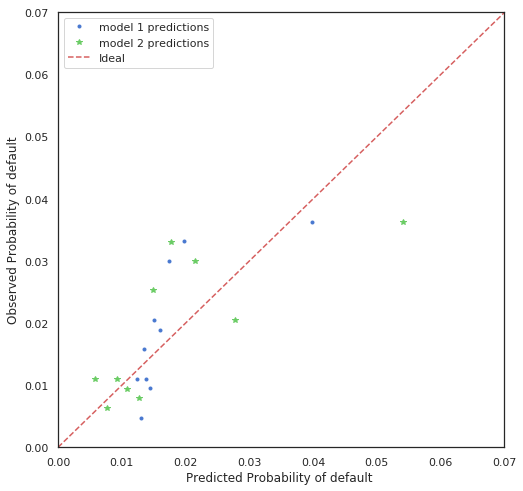

In [19]:
# just juect validation set
fig,ax = plt.subplots(figsize=(8,8))
sample = 'validation'
prob_true1,prob_pred1 = calibration.calibration_curve(scorecard_df.query('sample == "{}"'.format(sample)).target,scorecard_df.query('sample == "{}"'.format(sample)).model1,strategy='quantile',n_bins=10)
prob_true2,prob_pred2 = calibration.calibration_curve(scorecard_df.query('sample == "{}"'.format(sample)).target,scorecard_df.query('sample == "{}"'.format(sample)).model2,strategy='quantile',n_bins=10)
ax.plot(prob_pred1, prob_true1,'b.',label='model 1 predictions')
ax.plot(prob_pred2, prob_true2,'g*',label='model 2 predictions')
ax.plot(np.linspace(0,1), np.linspace(0,1), 'r--', label='Ideal')
ax.set_xlim((0,.07))
ax.set_ylim((0,.07))
ax.set_xlabel('Predicted Probability of default ')
ax.set_ylabel('Observed Probability of default')
plt.legend()

In [20]:
# how close is prob calibrated
print('MSR for model 1 the probablites being calibrated is {:2.1E}'.format(metrics.mean_squared_error(np.polyval([1,0],prob_true1) ,prob_pred1)))
print('MSR for model 2 the probablites being calibrated is {:2.1E}'.format(metrics.mean_squared_error(np.polyval([1,0],prob_true2) ,prob_pred2)))

MSR for model 1 the probablites being calibrated is 5.0E-05
MSR for model 2 the probablites being calibrated is 8.4E-05


Model 1 seems to be a better fit for an idealy callibrated model

# Predicted probably of default for each model

In [21]:
# without calibrating the model
scorecard_df.query('sample == "{}" and model1 <= {}'.format(sample,use_thresh1))[['model1','target']].mean()

model1    0.014442
target    0.015211
dtype: float64

In [22]:
scorecard_df.query('sample == "{}" and model2 <= {}'.format(sample,use_thresh2))[['model2','target']].mean()

model2    0.012543
target    0.016795
dtype: float64

Even though model 2 predicts to have a lower default rate, the true default rate is worse than model 1

# Conculsion

All the metrics point to Model 1 being the better model and should be used fot Portfolio A